# Scale and Shift of Gaussian Distribution using Tensorflow Bijector

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import tensorflow as tf
tf.enable_eager_execution()

tfd = tfp.distributions
tfb = tfp.bijectors


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
batch_size=512
target_dist = tfd.Normal(loc=5, scale=5)
target_samples = target_dist.sample(batch_size)

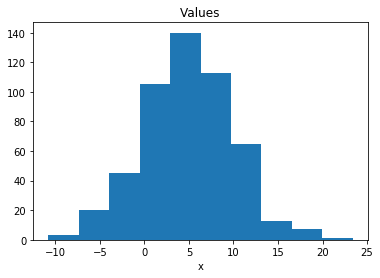

In [3]:
def draw_data(data):
    plt.hist(data)
    plt.title("Values")
    plt.xlabel("x")
    plt.show()
draw_data(target_samples)

In [4]:
mu = tf.Variable([1.0])
sigma = tf.Variable([1.0])

class ScaleAndShift(tfb.Bijector):
    def __init__(self, mu=0.0, sigma=0.0, validate_args=False, name="exp"):
        super(ScaleAndShift, self).__init__(
          validate_args=validate_args,
          forward_min_event_ndims=0,
          name=name)

    def forward(self, x):
        # Calling forward
        return x * sigma + mu

    def _inverse(self, y):
        return (y - mu) / sigma

    def _inverse_log_det_jacobian(self, y):
        return -self._forward_log_det_jacobian(self._inverse(y))

    def _forward_log_det_jacobian(self, x):
      # Notice that we needn't do any reducing, even when`event_ndims > 0`.
      # The base Bijector class will handle reducing for us; it knows how
      # to do so because we called `super` `__init__` with
      # `forward_min_event_ndims = 0`.
        return tf.log(sigma)

scale_shift = ScaleAndShift(mu, sigma)

In [5]:
base_dist = tfd.Normal(loc=0, scale=1)

dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=scale_shift
)

print (sigma)

<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([1.], dtype=float32)>


Instructions for updating:
Colocations handled automatically by placer.


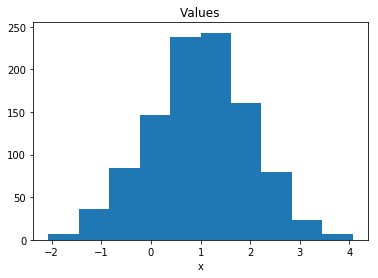

In [6]:
samples = dist.sample(1024)
draw_data(samples)

In [9]:

def loss():
    return -tf.reduce_mean(dist.log_prob(target_samples))

optimizer = tf.train.AdamOptimizer(learning_rate=0.2)
for i in range(1000):
    optimizer.minimize(loss, var_list=[mu, sigma])

print (mu)
print (sigma)

<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([4.9208164], dtype=float32)>
<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([5.0056963], dtype=float32)>


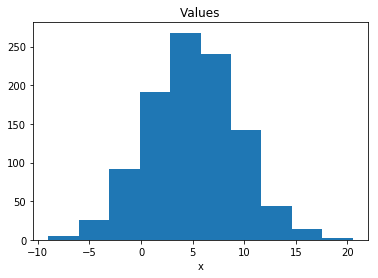

In [8]:
samples = dist.sample(1024)
draw_data(samples)